# Predicting house prices using k-nearest neighbors regression
In this notebook, you will implement k-nearest neighbors regression. You will:
  * Find the k-nearest neighbors of a given query input
  * Predict the output for the query input using the k-nearest neighbors
  * Choose the best value of k using a validation set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load in house sales data

For this notebook, we use a subset of the King County housing dataset created by randomly selecting 40% of the houses in the full dataset.

In [2]:
sales = pd.read_csv('kc_house_data.csv')
sales

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,...,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


# Import useful functions from previous notebooks

To efficiently compute pairwise distances among data points, we will convert the DataFrame into a 2D Numpy array. First import the numpy library and then copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [3]:
def  get_numpy_data(data_frame ,features , output):
    
    data_frame['constant'] = 1
    features = ['constant'] + features
    features_matrix = data_frame[features]
    output_matrix = output
    
    return features_matrix,output_matrix


We will also need the `normalize_features()` function from Week 5 that normalizes all feature columns to unit norm. Paste this function below.

In [4]:
def normalize_features(features_matrix):
    norms = np.linalg.norm(features_matrix,axis=0)
    normalized_feature = features_matrix/norms
    
    return normalized_feature, norms


# Split data into training, test, and validation sets

In [5]:
feature_list = ['bedrooms','bathrooms', 'sqft_living','sqft_lot','floors','waterfront','view','condition',
                'grade','sqft_above',  'sqft_basement','yr_built','yr_renovated', 'lat', 'long',  'sqft_living15','sqft_lot15']
x = sales[feature_list]
y = sales['price']
print(x.shape,y.shape)

(21613, 17) (21613,)


In [6]:
from sklearn.model_selection import train_test_split

(x_train_and_validation, x_test, y_train_and_validation, y_test) = train_test_split(x, y ,test_size = .2, random_state = 10) 
# initial train_valid/test split
(x_train, x_valid, y_train, y_valid) = train_test_split(x_train_and_validation, y_train_and_validation ,test_size = .2, random_state = 20) 
# initial train/valid split


In [7]:
print(x_train_and_validation.shape , y_train_and_validation.shape)

(17290, 17) (17290,)


In [8]:
print(x_train.shape , y_train.shape)

(13832, 17) (13832,)


In [9]:
print(x_valid.shape , y_valid.shape)

(3458, 17) (3458,)


In [10]:
print(x_test.shape , y_test.shape)

(4323, 17) (4323,)


# Extract features and normalize

Using all of the numerical inputs listed in `feature_list`, transform the training, test, and validation SFrames into Numpy arrays:

In [11]:

features_train, output_train = get_numpy_data(x_train, feature_list, y_train)
features_test, output_test = get_numpy_data(x_test, feature_list, x_test)
features_valid, output_valid = get_numpy_data(x_valid, feature_list, y_valid)

C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In computing distances, it is crucial to normalize features. Otherwise, for example, the `sqft_living` feature (typically on the order of thousands) would exert a much larger influence on distance than the `bedrooms` feature (typically on the order of ones). We divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.

IMPORTANT: Make sure to store the norms of the features in the training set. The features in the test and validation sets must be divided by these same norms, so that the training, test, and validation sets are normalized consistently.

In [12]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
#both above and below are pointing towards same point as to get matrix divided by norms

features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

# Compute a single distance

To start, let's just explore computing the "distance" between two given houses.  We will take our **query house** to be the first house of the test set and look at the distance between this house and the 10th house of the training set.

To see the features associated with the query house, print the first row (index 0) of the test feature matrix. You should get an 18-dimensional vector whose components are between 0 and 1.

In [13]:
features_train

,constant,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
5070,0.008503,0.007287,0.010370,0.010517,0.002568,0.010721,0.0,0.000000,0.007333,0.008773,0.008823,0.012287,0.008575,0.000000,0.008524,-0.008496,0.007648,0.002971
6943,0.008503,0.007287,0.005657,0.007934,0.001693,0.005360,0.0,0.000000,0.007333,0.007676,0.004585,0.016914,0.008368,0.000000,0.008518,-0.008516,0.006555,0.002277
20744,0.008503,0.004858,0.008485,0.003219,0.000140,0.010721,0.0,0.000000,0.007333,0.009870,0.003720,0.000000,0.008666,0.000000,0.008504,-0.008508,0.004451,0.000862
2262,0.008503,0.012146,0.013199,0.011527,0.001555,0.010721,0.0,0.000000,0.007333,0.008773,0.009991,0.012287,0.008640,0.000000,0.008536,-0.008486,0.012058,0.002364
17444,0.008503,0.012146,0.011313,0.013960,0.001102,0.008040,0.0,0.000000,0.007333,0.007676,0.009342,0.025052,0.008312,0.000000,0.008519,-0.008510,0.007648,0.001581
13745,0.008503,0.009717,0.006599,0.005913,0.001070,0.005360,0.0,0.000000,0.007333,0.007676,0.004887,0.007181,0.008399,0.000000,0.008510,-0.008509,0.003359,0.000282
3195,0.008503,0.009717,0.009428,0.013061,0.001810,0.008040,0.0,0.000000,0.009777,0.008773,0.015094,0.000000,0.008493,0.000000,0.008460,-0.008515,0.010278,0.002415
20495,0.008503,0.004858,0.007542,0.004154,0.000232,0.016081,0.0,0.000000,0.007333,0.007676,0.004239,0.002074,0.008662,0.000000,0.008501,-0.008515,0.004492,0.000313
19510,0.008503,0.007287,0.006599,0.006999,0.001684,0.005360,0.0,0.000000,0.007333,0.007676,0.004282,0.014042,0.008528,0.000000,0.008484,-0.008499,0.007081,0.002415
5770,0.008503,0.009717,0.007542,0.006063,0.000922,0.010721,0.0,0.000000,0.007333,0.007676,0.007007,0.000000,0.008235,0.000000,0.008501,-0.008509,0.006555,0.001294


In [14]:
print (features_test[:1])

     constant  bedrooms  bathrooms  sqft_living  sqft_lot   floors  \
957  0.008503  0.007287   0.006599     0.007859  0.002976  0.00536   

     waterfront  view  condition     grade  sqft_above  sqft_basement  \
957         0.0   0.0   0.009777  0.007676    0.009083            0.0   

     yr_built  yr_renovated       lat      long  sqft_living15  sqft_lot15  
957  0.008468           0.0  0.008467 -0.008492        0.00781    0.004955  


Now print the 10th row (index 9) of the training feature matrix. Again, you get an 18-dimensional vector with components between 0 and 1.

In [15]:
print(features_train.iloc[9])

constant         0.008503
bedrooms         0.009717
bathrooms        0.007542
sqft_living      0.006063
sqft_lot         0.000922
floors           0.010721
waterfront       0.000000
view             0.000000
condition        0.007333
grade            0.007676
sqft_above       0.007007
sqft_basement    0.000000
yr_built         0.008235
yr_renovated     0.000000
lat              0.008501
long            -0.008509
sqft_living15    0.006555
sqft_lot15       0.001294
Name: 5770, dtype: float64


***QUIZ QUESTION ***

What is the Euclidean distance between the query house and the 10th house of the training set? 

Note: Do not use the `np.linalg.norm` function; use `np.sqrt`, `np.sum`, and the power operator (`**`) instead. The latter approach is more easily adapted to computing multiple distances at once.

In [16]:
#print np.sqrt(np.sum((features_test[0]-features_train[9])**2))
print ("distance bw two {}" .format( np.sqrt(np.sum((features_test.iloc[0] - features_train.iloc[9]) ** 2)) ) )


distance bw two 0.00826395121635636


# Compute multiple distances

Of course, to do nearest neighbor regression, we need to compute the distance between our query house and *all* houses in the training set.  

To visualize this nearest-neighbor search, let's first compute the distance from our query house (`features_test[0]`) to the first 10 houses of the training set (`features_train[0:10]`) and then search for the nearest neighbor within this small set of houses.  Through restricting ourselves to a small set of houses to begin with, we can visually scan the list of 10 distances to verify that our code for finding the nearest neighbor is working.

Write a loop to compute the Euclidean distance from the query house to each of the first 10 houses in the training set.

In [17]:
min_nearest=np.inf
nearest=0
for i in range(10):
    distance=np.sqrt(np.sum((features_test.iloc[0]-features_train.iloc[i])**2))
    print('distance', distance)
    if distance < min_nearest:
        min_nearest=distance
        nearest=i
print ('nearest', nearest , 'min_nearest',min_nearest)

distance 0.014572738239542546
distance 0.0179887741686567
distance 0.011635896998775805
distance 0.017179193192179556
distance 0.027181184306806293
distance 0.011406975559569628
distance 0.009969890939880153
distance 0.014468088014282936
distance 0.015349216906361414
distance 0.00826395121635636
nearest 9 min_nearest 0.00826395121635636


*** QUIZ QUESTION ***

Among the first 10 training houses, which house is the closest to the query house?

In [18]:
nearest

9

It is computationally inefficient to loop over computing distances to all houses in our training dataset. Fortunately, many of the Numpy functions can be **vectorized**, applying the same operation over multiple values or vectors.  We now walk through this process.

Consider the following loop that computes the element-wise difference between the features of the query house (`features_test[0]`) and the first 3 training houses (`features_train[0:3]`):

In [19]:
for i in range(3):
    diff = features_train.iloc[i]-features_test.iloc[0]
    print(diff)
    # should print 3 vectors of length 18

constant         0.000000
bedrooms         0.000000
bathrooms        0.003771
sqft_living      0.002657
sqft_lot        -0.000408
floors           0.005360
waterfront       0.000000
view             0.000000
condition       -0.002444
grade            0.001097
sqft_above      -0.000260
sqft_basement    0.012287
yr_built         0.000108
yr_renovated     0.000000
lat              0.000057
long            -0.000004
sqft_living15   -0.000162
sqft_lot15      -0.001984
dtype: float64
constant         0.000000
bedrooms         0.000000
bathrooms       -0.000943
sqft_living      0.000075
sqft_lot        -0.001283
floors           0.000000
waterfront       0.000000
view             0.000000
condition       -0.002444
grade            0.000000
sqft_above      -0.004498
sqft_basement    0.016914
yr_built        -0.000099
yr_renovated     0.000000
lat              0.000050
long            -0.000024
sqft_living15   -0.001254
sqft_lot15      -0.002679
dtype: float64
constant         0.000000
bedrooms

The subtraction operator (`-`) in Numpy is vectorized as follows:

In [20]:
#both above and below are same for extracting
print (features_train.iloc[0:3] - features_test.iloc[0] )

       constant  bedrooms  bathrooms  sqft_living  sqft_lot   floors  \
5070        0.0  0.000000   0.003771     0.002657 -0.000408  0.00536   
6943        0.0  0.000000  -0.000943     0.000075 -0.001283  0.00000   
20744       0.0 -0.002429   0.001886    -0.004641 -0.002837  0.00536   

       waterfront  view  condition     grade  sqft_above  sqft_basement  \
5070          0.0   0.0  -0.002444  0.001097   -0.000260       0.012287   
6943          0.0   0.0  -0.002444  0.000000   -0.004498       0.016914   
20744         0.0   0.0  -0.002444  0.002193   -0.005363       0.000000   

       yr_built  yr_renovated       lat      long  sqft_living15  sqft_lot15  
5070   0.000108           0.0  0.000057 -0.000004      -0.000162   -0.001984  
6943  -0.000099           0.0  0.000050 -0.000024      -0.001254   -0.002679  
20744  0.000198           0.0  0.000036 -0.000016      -0.003359   -0.004093  


Note that the output of this vectorized operation is identical to that of the loop above, which can be verified below:

In [21]:
# verify that vectorization works
results = features_train.iloc[0:3] - features_test.iloc[0]
print (results.iloc[0] - (features_train.iloc[0] - features_test.iloc[0]) )
# should print all 0's if results[0] == (features_train[0]-features_test[0])
print ( results.iloc[1] - (features_train.iloc[1] - features_test.iloc[0] ) )
# should print all 0's if results[1] == (features_train[1]-features_test[0])
print ( results.iloc[2] - (features_train.iloc[2] - features_test.iloc[0] ) )
# should print all 0's if results[2] == (features_train[2]-features_test[0])

constant         0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
waterfront       0.0
view             0.0
condition        0.0
grade            0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
yr_renovated     0.0
lat              0.0
long             0.0
sqft_living15    0.0
sqft_lot15       0.0
dtype: float64
constant         0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
waterfront       0.0
view             0.0
condition        0.0
grade            0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
yr_renovated     0.0
lat              0.0
long             0.0
sqft_living15    0.0
sqft_lot15       0.0
dtype: float64
constant         0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
waterfront       0.0
view             0.0
condition        0.0
grade            0.0
sqft

Aside: it is a good idea to write tests like this cell whenever you are vectorizing a complicated operation.

# Perform 1-nearest neighbor regression

Now that we have the element-wise differences, it is not too hard to compute the Euclidean distances between our query house and all of the training houses. First, write a single-line expression to define a variable `diff` such that `diff[i]` gives the element-wise difference between the features of the query house and the `i`-th training house.

In [22]:
diff = (features_test.iloc[0]-features_train)
diff

,constant,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
5070,0.0,0.000000,-0.003771,-0.002657,0.000408,-0.005360,0.0,0.000000,0.002444,-0.001097,0.000260,-0.012287,-0.000108,0.000000,-5.674336e-05,3.826513e-06,0.000162,0.001984
6943,0.0,0.000000,0.000943,-0.000075,0.001283,0.000000,0.0,0.000000,0.002444,0.000000,0.004498,-0.016914,0.000099,0.000000,-5.034320e-05,2.393310e-05,0.001254,0.002679
20744,0.0,0.002429,-0.001886,0.004641,0.002837,-0.005360,0.0,0.000000,0.002444,-0.002193,0.005363,0.000000,-0.000198,0.000000,-3.648809e-05,1.607136e-05,0.003359,0.004093
2262,0.0,-0.004858,-0.006599,-0.003668,0.001421,-0.005360,0.0,0.000000,0.002444,-0.001097,-0.000908,-0.012287,-0.000173,0.000000,-6.850680e-05,-5.704983e-06,-0.004249,0.002592
17444,0.0,-0.004858,-0.004714,-0.006100,0.001874,-0.002680,0.0,0.000000,0.002444,0.000000,-0.000260,-0.025052,0.000155,0.000000,-5.157675e-05,1.815854e-05,0.000162,0.003374
13745,0.0,-0.002429,0.000000,0.001946,0.001906,0.000000,0.0,0.000000,0.002444,0.000000,0.004195,-0.007181,0.000069,0.000000,-4.256646e-05,1.718452e-05,0.004451,0.004674
3195,0.0,-0.002429,-0.002828,-0.005202,0.001167,-0.002680,0.0,0.000000,0.000000,-0.001097,-0.006012,0.000000,-0.000026,0.000000,7.580084e-06,2.275036e-05,-0.002468,0.002541
20495,0.0,0.002429,-0.000943,0.003705,0.002745,-0.010721,0.0,0.000000,0.002444,0.000000,0.004844,-0.002074,-0.000194,0.000000,-3.350254e-05,2.288951e-05,0.003318,0.004642
19510,0.0,0.000000,0.000000,0.000861,0.001293,0.000000,0.0,0.000000,0.002444,0.000000,0.004801,-0.014042,-0.000060,0.000000,-1.641160e-05,7.305161e-06,0.000728,0.002541
5770,0.0,-0.002429,-0.000943,0.001796,0.002054,-0.005360,0.0,0.000000,0.002444,0.000000,0.002076,0.000000,0.000233,0.000000,-3.416401e-05,1.725410e-05,0.001254,0.003662


To test the code above, run the following cell, which should output a value -0.016990276636148563:

In [23]:
print (diff.iloc[-1].sum()) # sum of the feature differences between the query and last training house
# should print -0.016990276636148563

-0.016990276636148563


The next step in computing the Euclidean distances is to take these feature-by-feature differences in `diff`, square each, and take the sum over feature indices.  That is, compute the sum of square feature differences for each training house (row in `diff`).

By default, `np.sum` sums up everything in the matrix and returns a single number. To instead sum only over a row or column, we need to specifiy the `axis` parameter described in the `np.sum` [documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.sum.html). In particular, `axis=1` computes the sum across each row.

Below, we compute this sum of square feature differences for all training houses and verify that the output for the 16th house in the training set is equivalent to having examined only the 16th row of `diff` and computing the sum of squares on that row alone.

In [24]:
d1 = np.sum(diff**2, axis=1)
print (d1.iloc[15]) 
# take sum of squares across each row, and print the 16th sum
d2 = diff.iloc[15]**2
print (np.sum(d2) )# print the sum of squares for the 16th row -- should be same as above

0.0004275324848034081
0.0004275324848034081


   Its just explanation part of above , no reviewing needed

a1 = diff**2
#print(a1)

d1 = np.sum(a1, axis=1)
print (d1.iloc[15]) 
#take sum of squares across each row, and print the 16th sum
d2 = diff.iloc[15]

#print(d2**2)

print (np.sum(d2**2) )# print the sum of squares for the 16th row -- should be same as above

With this result in mind, write a single-line expression to compute the Euclidean distances between the query house and all houses in the training set. Assign the result to a variable `distances`.

**Hint**: Do not forget to take the square root of the sum of squares.

In [25]:
distances=np.sqrt(np.sum(diff**2, axis=1))


To test the code above, run the following cell, which should output a value 0.0237082324496:

In [26]:
print (distances.iloc[100]) # Euclidean distance between the query house and the 101th training house
# should print 0.008305417474245421

0.008305417474245421


Now you are ready to write a function that computes the distances from a query house to all training houses. The function should take two parameters: (i) the matrix of training features and (ii) the single feature vector associated with the query.

In [27]:
def compute_distances(training_features,query):
    
    diff = query-training_features
    distances=np.sqrt(np.sum(diff**2, axis=1))
    
    return distances

*** QUIZ QUESTIONS ***

1.  Take the query house to be third house of the test set (`features_test[2]`).  What is the index of the house in the training set that is closest to this query house?
2.  What is the predicted value of the query house based on 1-nearest neighbor regression?

In [28]:
distances=compute_distances(features_train,features_test.iloc[2])
print (np.argmin(distances))
#argmin will give min value of distances

5832


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [29]:
distances.sort_values()

5832     0.005183
17394    0.007123
12075    0.007161
350      0.007541
8623     0.007544
4651     0.008301
13057    0.008622
15293    0.008871
8600     0.008968
14466    0.009372
1975     0.009429
12418    0.009697
13629    0.009707
9165     0.009809
14366    0.009945
1378     0.010013
7973     0.010061
17581    0.010106
17580    0.010106
17363    0.010126
18052    0.010128
15337    0.010196
2223     0.010204
3285     0.010237
15217    0.010248
11416    0.010263
794      0.010340
10424    0.010352
5730     0.010359
8262     0.010362
           ...   
4762     0.116415
18722    0.116541
5760     0.116633
6233     0.116747
3252     0.116816
12459    0.117345
17657    0.117699
8156     0.117742
3934     0.119946
18199    0.120336
2864     0.120491
1315     0.122071
16995    0.122277
16188    0.124604
14688    0.125309
15482    0.125797
8664     0.130981
12777    0.135199
13477    0.138408
2964     0.143341
8092     0.146613
7294     0.148484
13006    0.165469
13464    0.179348
7077     0

In [30]:
output_train.iloc[5832]# check price of 5832 index from train data

455000.0

# Perform k-nearest neighbor regression

For k-nearest neighbors, we need to find a *set* of k houses in the training set closest to a given query house. We then make predictions based on these k nearest neighbors.

## Fetch k-nearest neighbors

Using the functions above, implement a function that takes in
 * the value of k;
 * the feature matrix for the training houses; and
 * the feature vector of the query house
 
and returns the indices of the k closest training houses. For instance, with 2-nearest neighbor, a return value of [5, 10] would indicate that the 6th and 11th training houses are closest to the query house.

**Hint**: Look at the [documentation for `np.argsort`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html).

In [31]:
def k_nearest_neighbours(k,training_features,query):
    
    distances=compute_distances(training_features,query)
    s= np.argsort(distances)[0:k]# it (argsort)will sort the distances values and give index from 0 to k
    return s

*** QUIZ QUESTION ***

Take the query house to be third house of the test set (`features_test[2]`).  What are the indices of the 4 training houses closest to the query house?

In [32]:
k_nearest = k_nearest_neighbours(4,features_train,features_test.iloc[2])
print (k_nearest)
print (output_train[k_nearest])
#checking respected output for those values

5070      7649
6943     12767
20744    11178
2262      7425
dtype: int64
7649     575000.0
12767    452500.0
11178         NaN
7425     670000.0
Name: price, dtype: float64


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\pandas\core\series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


## Make a single prediction by averaging k nearest neighbor outputs

Now that we know how to find the k-nearest neighbors, write a function that predicts the value of a given query house. **For simplicity, take the average of the prices of the k nearest neighbors in the training set**. The function should have the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature vector of the query house, whose price we are predicting.
 
The function should return a predicted value of the query house.

**Hint**: You can extract multiple items from a Numpy array using a list of indices. For instance, `output_train[[6, 10]]` returns the prices of the 7th and 11th training houses.

In [33]:
def k_predict(k,features_train,output_train,query):
    
    k_nearest=k_nearest_neighbours(k,features_train,query)
    ss=np.sum(output_train[k_nearest])/len(k_nearest)
    
    return ss

*** QUIZ QUESTION ***

Again taking the query house to be third house of the test set (`features_test[2]`), predict the value of the query house using k-nearest neighbors with `k=4` and the simple averaging method described and implemented above.

In [34]:
print (k_predict(4,features_train,output_train,features_test.iloc[2]) )

424375.0


Compare this predicted value using 4-nearest neighbors to the predicted value using 1-nearest neighbor computed earlier.

## Make multiple predictions

Write a function to predict the value of *each and every* house in a query set. (The query set can be any subset of the dataset, be it the test set or validation set.) The idea is to have a loop where we take each house in the query set as the query house and make a prediction for that specific house. The new function should take the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature matrix for the query set.
 
The function should return a set of predicted values, one for each house in the query set.

**Hint**: To get the number of houses in the query set, use the `.shape` field of the query features matrix. See [the documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.ndarray.shape.html).

In [35]:
def predict_all(k,features_train,output_train,query):
    predictions=[]
    query_length=len(query)
    
    for i in range(query_length):
        predictions.append(k_predict(k,features_train,output_train,query.iloc[i]))
    
    return predictions

*** QUIZ QUESTION ***

Make predictions for the first 10 houses in the test set using k-nearest neighbors with `k=10`. 

1. What is the index of the house in this query set that has the lowest predicted value? 
2. What is the predicted value of this house?

In [36]:
print (predict_all(10,features_train,output_train,features_test.iloc[0:5]) )

[360090.0, 239700.0, 453145.0, 451225.0, 468877.0]


In [44]:
test_out = predict_all(10,features_train,output_train,features_test) 
print (len(test_out) ,features_test.shape ,test_out)

4323 (4323, 18) [360090.0, 239700.0, 453145.0, 451225.0, 468877.0, 410545.0, 278300.0, 395250.0, 300314.0, 427800.0, 425292.5, 421345.0, 270214.3, 323095.0, 360132.0, 313075.0, 226100.1, 426205.9, 432425.2, 275340.0, 247000.0, 230300.0, 274219.5, 310009.0, 371450.0, 471385.0, 330220.0, 357908.8, 364400.0, 390100.0, 404162.6, 679095.0, 336245.0, 256530.0, 473620.0, 178999.9, 269965.0, 429650.0, 505070.0, 166895.0, 381450.0, 300600.0, 233330.0, 224310.0, 314900.0, 134524.1, 560000.0, 455440.0, 469300.0, 413360.0, 154800.0, 658450.0, 473987.5, 359400.0, 551149.0, 333676.0, 444090.0, 112000.0, 367675.0, 261000.0, 463795.0, 317300.0, 235285.0, 199247.5, 303495.0, 307280.0, 252564.0, 353095.0, 447550.0, 372450.0, 239200.0, 607440.0, 160605.3, 334350.0, 120525.0, 409250.0, 471295.0, 324350.0, 574800.0, 160300.0, 220000.0, 330200.0, 317845.0, 269900.0, 271200.0, 438674.0, 485850.0, 477870.0, 401455.0, 362600.0, 347745.0, 311500.0, 393445.0, 357580.0, 430500.0, 280550.0, 476200.0, 627350.0, 487

## Choosing the best value of k using a validation set

There remains a question of choosing the value of k to use in making predictions. Here, we use a validation set to choose this value. Write a loop that does the following:

* For `k` in [1, 2, ..., 15]:
    * Makes predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
    * Computes the RSS for these predictions on the VALIDATION set
    * Stores the RSS computed above in `rss_all`
* Report which `k` produced the lowest RSS on VALIDATION set.

(Depending on your computing environment, this computation may take 10-15 minutes.)

In [57]:
# start K value from atleast  10, below these no its not working ..showing erros 
k = 10 
print( predict_all(10,features_train,output_train,features_valid) )

[362260.0, 235700.5, 237270.0, 193650.0, 254220.0, 252075.0, 435185.0, 40500.0, 360150.0, 100490.0, 211995.0, 281976.0, 248875.0, 400066.1, 515000.0, 357915.3, 186588.8, 327950.0, 331875.0, 466485.0, 350374.5, 340840.0, 385195.0, 264993.4, 391775.0, 304750.0, 715850.0, 369385.0, 322250.0, 256665.0, 406538.8, 265984.0, 277400.0, 293190.0, 159100.0, 422445.0, 240900.0, 524080.0, 281740.0, 319300.0, 49850.0, 236300.0, 318560.0, 565850.0, 171950.0, 506800.0, 495150.0, 319150.0, 328940.0, 391090.0, 434165.0, 533249.0, 332950.0, 323825.1, 680800.0, 202200.0, 528275.0, 321840.0, 359850.0, 386639.9, 452975.0, 146913.5, 264400.0, 217245.0, 457200.0, 288150.0, 299685.0, 229080.0, 147700.0, 522735.0, 258740.0, 276000.0, 455100.0, 301850.0, 316104.0, 318470.0, 334000.0, 464770.0, 307580.0, 203700.0, 249700.0, 318150.0, 184350.0, 325102.5, 236310.0, 411990.0, 198750.0, 755850.0, 231100.0, 327475.0, 273020.0, 853000.0, 329290.0, 385785.0, 325800.0, 368349.0, 266700.0, 566600.0, 430000.0, 169650.0, 3

In [58]:
rss_all=[]
for k in range(10,20):
    predictions = predict_all(k,features_train,output_train,features_valid)
    res = output_valid - predictions
    rss = (res**2).sum()
    rss_all.append(rss)
print (rss_all)

[644897681129307.8, 640484363619497.6, 636419132662253.8, 634402461103264.8, 632064003701275.0, 627965054210669.1, 625592161041739.5, 621885038265559.0, 620144146622007.4, 617014360028489.4]


To visualize the performance as a function of `k`, plot the RSS on the VALIDATION set for each considered `k` value:

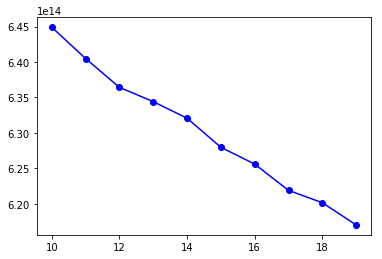

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(10, 20)
plt.plot(kvals, rss_all,'bo-')

***QUIZ QUESTION ***

What is the RSS on the TEST data using the value of k found above?  To be clear, sum over all houses in the TEST set.

In [60]:
rss_all[7]

621885038265559.0